## Examine factors associated with birth count variation among US counties using Principal Components Regression and Poisson GLM/GEE.

In [1]:
import pandas as pd
import numpy as np
from prep import births, demog, pop, na, age_groups, rucc
import statsmodels.api as sm
import matplotlib.pyplot as plt

View some of the raw data:

In [2]:
births.head()

,County,FIPS,Births,year
0,"Baldwin County, AL",01003,2157.0,2011
1,"Calhoun County, AL",01015,1418.0,2011
2,"Etowah County, AL",01055,1173.0,2011
3,"Jefferson County, AL",01073,8916.0,2011
4,"Lee County, AL",01081,1536.0,2011


In [3]:
pop.head()

,FIPS,Population
0,01001,55302
1,01003,207787
2,01005,25828
3,01007,22590
4,01009,57487


In [4]:
rucc.head()

,FIPS,RUCC_2013
0,01001,2.0
1,01003,3.0
2,01005,6.0
3,01007,1.0
4,01009,1.0


In [5]:
demog.head()

,W_N_M_0,W_N_M_1,W_N_M_2,W_N_M_3,W_N_M_4,W_N_M_5,W_N_M_6,W_N_M_7,W_N_M_8,W_N_M_9,...,B_H_M_18,N_H_M_17,A_H_F_12,N_H_M_18,A_H_M_17,A_H_M_16,A_H_F_16,A_H_F_17,N_H_M_16,A_H_F_18
FIPS,,,,,,,,,,,,,,,,,,,,,
01001,238.0,961.0,1373.0,1410.0,1434.0,1218.0,1286.0,1243.0,1282.0,1382.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01003,916.0,3696.0,4928.0,5318.0,5044.0,4326.0,4592.0,4625.0,4958.0,5176.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01005,41.0,198.0,269.0,271.0,306.0,361.0,427.0,391.0,403.0,447.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01007,108.0,355.0,509.0,563.0,539.0,476.0,573.0,545.0,559.0,605.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01009,268.0,1131.0,1518.0,1534.0,1635.0,1436.0,1456.0,1347.0,1493.0,1538.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Create a dataframe for modeling.  Merge the birth data with population and RUCC data.

In [6]:
da = pd.merge(births, pop, on="FIPS", how="left")
da = pd.merge(da, rucc, on="FIPS", how="left")

Population will be used as an offset below.

In [7]:
da["logPop"] = np.log(da["Population"])
da = da.dropna()
da = da.sort_values(["FIPS", "year"])
da.head()

,County,FIPS,Births,year,Population,RUCC_2013,logPop
0,"Baldwin County, AL",01003,2157.0,2011,207787,3.0,12.244269
524,"Baldwin County, AL",01003,2109.0,2012,207787,3.0,12.244269
1048,"Baldwin County, AL",01003,2160.0,2013,207787,3.0,12.244269
1572,"Baldwin County, AL",01003,2244.0,2014,207787,3.0,12.244269
2150,"Baldwin County, AL",01003,2344.0,2015,207787,3.0,12.244269


Create centered versions of some variables.

In [8]:
da["yearc"] = da["year"] - da["year"].mean()
da["logPopc"] = da["logPop"] - da["logPop"].mean()
da["RUCC_2013c"] = da["RUCC_2013"] - da["RUCC_2013"].mean()

Calculate the mean and variance within each county to assess the mean/variance relationship.

In [9]:
mv = births.groupby("FIPS")["Births"].agg([np.mean, np.var])
lmv = np.log(mv)

Regress log variance on log mean

In [10]:
mr = sm.OLS.from_formula("var ~ mean", lmv).fit()
print(mr.summary())

                            OLS Regression Results                            
Dep. Variable:                    var   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     2042.
Date:                Wed, 07 Feb 2024   Prob (F-statistic):          7.38e-192
Time:                        09:58:26   Log-Likelihood:                -735.05
No. Observations:                 580   AIC:                             1474.
Df Residuals:                     578   BIC:                             1483.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.4898      0.338    -16.231      0.0

Plot the log variance against the log mean.  If variance = phi * mean, then log(variance) = log(phi) + log(mean), i.e. the slope is 1 and the intercept is log(phi).  If variance = phi * mean^a then log(variance) = log(phi) + a * log(mean).

Text(0, 0.5, 'Log variance')

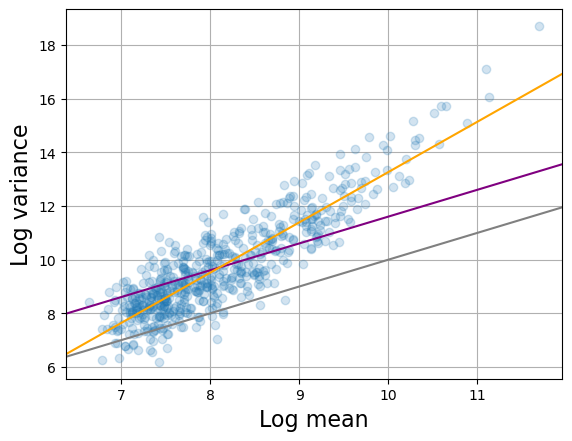

In [11]:
plt.clf()
plt.grid(True)
plt.plot(lmv["mean"], lmv["var"], "o", alpha=0.2, rasterized=True)
plt.axline((8, 8), slope=1, color="grey")
plt.axline((lmv["mean"].mean(0), lmv["var"].mean(0)), slope=1, color="purple")
plt.axline((8, mr.params[0]+8*mr.params[1]), slope=mr.params[1], color="orange")
plt.xlabel("Log mean", size=16)
plt.ylabel("Log variance", size=16)

GLM, not appropriate since we have repeated measures on counties

In [12]:
fml = "Births ~ logPop + RUCC_2013"
m0 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r0 = m0.fit() # Poisson
r0x = m0.fit(scale="X2") # Quasi-Poisson
r0x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5618
Model:                            GLM   Df Residuals:                     5615
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          133.05
Method:                          IRLS   Log-Likelihood:                -2975.4
Date:                Wed, 07 Feb 2024   Deviance:                   7.3576e+05
Time:                        09:58:26   Pearson chi2:                 7.47e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9151      0.035   -139.701      0.000      -4.984      -4.846
logPop         1.0346      0.002    445.449      0.000       1.030       1.039
RUCC_2013      0.0250      0.004      6.477      0.000       0.017       0.033
==============================================================================
"""

GEE accounts for the correlated data

In [13]:
m1 = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Poisson(), data=da)
r1 = m1.fit() # Poisson and quasi-Poisson are the same for GEE
r1x = m1.fit(scale="X2")
r1x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 07 Feb 2024   Scale:                         133.052
Covariance type:                    robust   Time:                         09:58:27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.9151      0.190    -25.833      0.000      -5.288      -4.542
logPop         1.0346      0.013     77.405      0.000       1.008       1.061
RUCC_2013      0.0250      0.014      1.842      0.065      -0.002       0.052
==============================================================================
Skew:                         -4.2707   Kurtosis:                     134.1520
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Use log population as an offset instead of a covariate

In [14]:
m2 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Poisson(), data=da)
r2 = m2.fit(scale="X2")
r2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                            Poisson   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 07 Feb 2024   Scale:                         137.859
Covariance type:                    robust   Time:                         09:58:27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.3963      0.019   -232.699      0.000      -4.433      -4.359
RUCC_2013     -0.0095      0.010     -0.931      0.352      -0.030       0.011
==============================================================================
Skew:                          1.2162   Kurtosis:                      56.8103
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

A diagnostic plot for the variance structure that does not require there to be replicates.

Text(0, 0.5, 'Absolute Pearson residual')

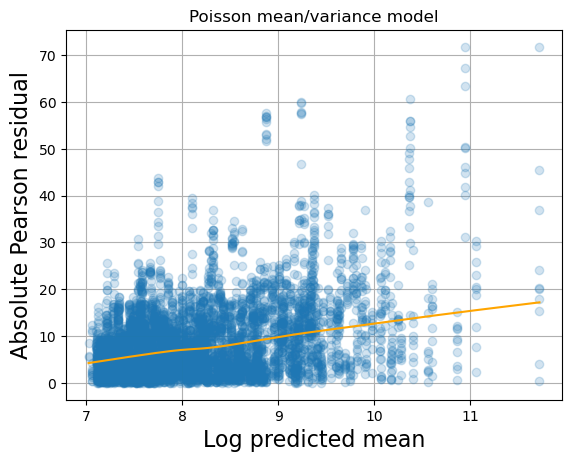

In [15]:
plt.clf()
plt.grid(True)
lfv = np.log(r2.fittedvalues).values
apr = np.abs(r2.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Poisson mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Use Gamma family to better match the mean/variance relationship.

In [16]:
m3 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r3 = m3.fit(scale="X2")
r3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 07 Feb 2024   Scale:                           0.033
Covariance type:                    robust   Time:                         09:58:27
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4436      0.015   -287.071      0.000      -4.474      -4.413
RUCC_2013      0.0031      0.008      0.388      0.698      -0.013       0.019
==============================================================================
Skew:                          3.3915   Kurtosis:                      46.1832
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Diagnostic plot for mean/variance relationship with gamma model.

Text(0, 0.5, 'Absolute Pearson residual')

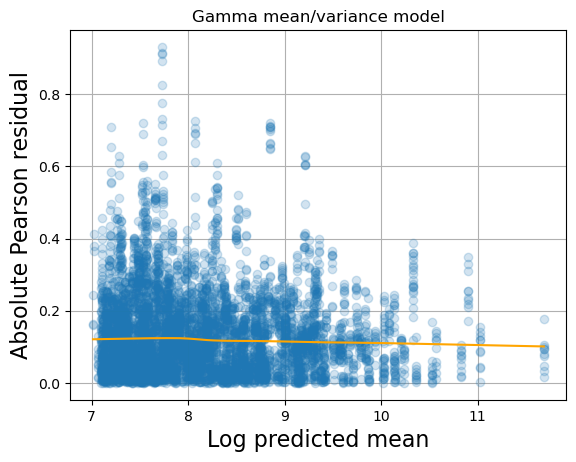

In [17]:
plt.clf()
plt.grid(True)
lfv = np.log(r3.fittedvalues).values
apr = np.abs(r3.resid_pearson)
ii = np.argsort(lfv)
lfv = lfv[ii]
apr = apr[ii]
ff = sm.nonparametric.lowess(apr, lfv)
plt.plot(lfv, apr, "o", alpha=0.2, rasterized=True)
plt.plot(ff[:, 0], ff[:, 1], "-", color="orange")
plt.title("Gamma mean/variance model")
plt.xlabel("Log predicted mean", size=16)
plt.ylabel("Absolute Pearson residual", size=16)

Use exchangeable correlation structure.  Since RUCC is constant within groups the parameter estimates and standard errors are the same as with the independence model.

In [18]:
m4 = sm.GEE.from_formula("Births ~ RUCC_2013", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r4 = m4.fit(scale="X2")
r4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Wed, 07 Feb 2024   Scale:                           0.033
Covariance type:                    robust   Time:                         09:58:28
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4425      0.015   -288.245      0.000      -4.473      -4.412
RUCC_2013      0.0030      0.008      0.366      0.714      -0.013       0.019
==============================================================================
Skew:                          3.3426   Kurtosis:                      46.3173
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

In [19]:
m5 = sm.GEE.from_formula("Births ~ RUCC_2013 + year", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r5 = m5.fit(scale="X2")
r5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Wed, 07 Feb 2024   Scale:                           0.032
Covariance type:                    robust   Time:                         09:58:28
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.1032      0.915     12.133      0.000       9.310      12.897
RUCC_2013      0.0030      0.008      0.368      0.713      -0.013       0.019
year          -0.0077      0.000    -17.004      0.000      -0.009      -0.007
==============================================================================
Skew:                          3.7955   Kurtosis:                      42.3647
Centered skew:                -8.8791   Centered kurtosis:            409.1697
==============================================================================
"""

In [38]:
m6 = sm.GEE.from_formula("Births ~ RUCC_2013c * yearc", groups="FIPS", offset="logPop",
                         cov_struct=sm.cov_struct.Exchangeable(),
                         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r6 = m6.fit(scale="X2")
r6.summary()
#da.RUCC_2013.mean()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Exchangeable   Num. iterations:                     8
Date:                     Wed, 07 Feb 2024   Scale:                           0.032
Covariance type:                    robust   Time:                         11:11:59
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.4368      0.007   -611.740      0.000      -4.451      -4.423
RUCC_2013c           0.0032      0.008      0.390      0.696      -0.013       0.019
yearc               -0.0077      0.000    -17.385      0.000      -0.009      -0.007
RUCC_2013c:yearc    -0.0027      0.000     -5.588      0.000      -0.004      -0.002
==============================================================================
Skew:                          3.6734   Kurtosis:                      43.3111
Centered skew:                -8.9418   Centered kurtosis:            423.3549
==============================================================================
"""

Score tests comparing pairs of nested models:

In [21]:
print(r5.model.compare_score_test(r4))
print(r6.model.compare_score_test(r5))

{'statistic': 181.88354493118266, 'df': 1, 'p-value': 0.0}
{'statistic': 26.534748712065376, 'df': 1, 'p-value': 2.5884009346999193e-07}


Get factors (principal components) from the demographic data

In [22]:
demogx = np.asarray(demog)
demogx = np.power(demogx, 0.25)
demogx -= demogx.mean()
demogx -= demogx.mean(0)
demogx -= demogx.mean(1)[:, None]
u, s, vt = np.linalg.svd(demogx, 0)
v = vt.T

Convert the coefficients back to the original coordinates

In [23]:
def convert_coef(c, npc):
    return np.dot(v[:, 0:npc], c/s[0:npc])

Put the demographic factors into a dataframe

In [24]:
m = {("pc%02d" % k) : u[:, k] for k in range(100)}
m["FIPS"] = demog.index
demog_f = pd.DataFrame(m)

Merge demographic information into the births data

In [25]:
da = pd.merge(da, demog_f, on="FIPS", how="left")

Include this number of factors in subsequent models

In [26]:
npc = 10

A GLM, not appropriate since we have repeated measures on counties

In [27]:
fml = "Births ~ (logPopc + RUCC_2013c) * yearc + " + " + ".join(["pc%02d" % j for j in range(npc)])
m7 = sm.GLM.from_formula(fml, family=sm.families.Poisson(), data=da)
r7 = m7.fit(scale="X2")
r7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Births   No. Observations:                 5618
Model:                            GLM   Df Residuals:                     5602
Model Family:                 Poisson   Df Model:                           15
Link Function:                    Log   Scale:                          49.491
Method:                          IRLS   Log-Likelihood:                -3326.1
Date:                Wed, 07 Feb 2024   Deviance:                   2.7322e+05
Time:                        09:58:29   Pearson chi2:                 2.77e+05
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.2384      0.006   1464.907      0.000       8.227       8.249
logPopc              1.1228      0.005    212.817      0.000       1.112       1.133
RUCC_2013c           0.0369      0.003     13.504      0.000       0.032       0.042
yearc               -0.0062      0.001    -10.258      0.000      -0.007      -0.005
logPopc:yearc       -0.0053      0.001    -10.560      0.000      -0.006      -0.004
RUCC_2013c:yearc    -0.0057      0.001     -6.844      0.000      -0.007      -0.004
pc00                 3.8593      0.187     20.611      0.000       3.492       4.226
pc01                 1.6573      0.065     25.382      0.000       1.529       1.785
pc02                 1.3691      0.053     25.743      0.000       1.265       1.473
pc03                -0.0895      0.077     -1.159      0.247      -0.241       0.062
pc04                -1.0044      0.052    -19.260      0.000      -1.107      -0.902
pc05                 2.7060      0.051     53.391      0.000       2.607       2.805
pc06                -1.3680      0.057    -24.006      0.000      -1.480      -1.256
pc07                 1.4906      0.047     31.896      0.000       1.399       1.582
pc08                -2.2485      0.103    -21.920      0.000      -2.450      -2.047
pc09                 0.0642      0.062      1.031      0.303      -0.058       0.186
====================================================================================
"""

GEE accounts for the correlated data

In [28]:
m8 = sm.GEE.from_formula(fml, groups="FIPS",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r8 = m8.fit(scale="X2")
r8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 07 Feb 2024   Scale:                           0.011
Covariance type:                    robust   Time:                         09:58:29
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            8.2744      0.027    306.476      0.000       8.222       8.327
logPopc              1.1374      0.020     55.530      0.000       1.097       1.177
RUCC_2013c           0.0396      0.006      6.202      0.000       0.027       0.052
yearc               -0.0075      0.000    -15.393      0.000      -0.008      -0.007
logPopc:yearc       -0.0024      0.001     -2.947      0.003      -0.004      -0.001
RUCC_2013c:yearc    -0.0036      0.001     -4.828      0.000      -0.005      -0.002
pc00                 4.9390      0.869      5.684      0.000       3.236       6.642
pc01                 2.4427      0.279      8.767      0.000       1.897       2.989
pc02                 1.8071      0.212      8.528      0.000       1.392       2.222
pc03                -0.0234      0.298     -0.079      0.937      -0.607       0.560
pc04                -0.7482      0.225     -3.320      0.001      -1.190      -0.307
pc05                 3.1885      0.232     13.744      0.000       2.734       3.643
pc06                -1.4736      0.249     -5.928      0.000      -1.961      -0.986
pc07                 2.3312      0.255      9.147      0.000       1.832       2.831
pc08                -1.7593      0.363     -4.853      0.000      -2.470      -1.049
pc09                 1.5702      0.234      6.714      0.000       1.112       2.028
==============================================================================
Skew:                          2.3322   Kurtosis:                     103.7337
Centered skew:                -8.4615   Centered kurtosis:            356.1710
==============================================================================
"""

Use log population as an offset instead of a covariate

In [29]:
fml = "Births ~ " + " + ".join(["pc%02d" % j for j in range(npc)])
m9 = sm.GEE.from_formula(fml, groups="FIPS", offset="logPop",
         family=sm.families.Gamma(link=sm.families.links.log()), data=da)
r9 = m9.fit(scale="X2")
r9.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      Births   No. Observations:                 5618
Model:                                 GEE   No. clusters:                      580
Method:                        Generalized   Min. cluster size:                   3
                      Estimating Equations   Max. cluster size:                  10
Family:                              Gamma   Mean cluster size:                 9.7
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Wed, 07 Feb 2024   Scale:                           0.013
Covariance type:                    robust   Time:                         09:58:29
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4545      0.010   -434.768      0.000      -4.475      -4.434
pc00           0.3014      0.315      0.958      0.338      -0.316       0.918
pc01           1.1403      0.192      5.930      0.000       0.763       1.517
pc02           2.6074      0.179     14.586      0.000       2.257       2.958
pc03           1.2338      0.240      5.144      0.000       0.764       1.704
pc04          -1.3636      0.191     -7.126      0.000      -1.739      -0.989
pc05           2.9190      0.244     11.980      0.000       2.441       3.397
pc06          -0.9959      0.254     -3.919      0.000      -1.494      -0.498
pc07           1.9646      0.253      7.771      0.000       1.469       2.460
pc08          -1.3427      0.370     -3.633      0.000      -2.067      -0.618
pc09           1.2810      0.236      5.417      0.000       0.817       1.744
==============================================================================
Skew:                         -3.0783   Kurtosis:                      64.9871
Centered skew:                -8.0870   Centered kurtosis:            394.3324
==============================================================================
"""

Restructure the coefficients so that the age bands are in the columns.

In [30]:
def restructure(c):
    ii = pd.MultiIndex.from_tuples(na)
    c = pd.Series(c, index=ii)
    c = c.unstack()
    return c

This function fits a Poisson GLM to the data using 'npc' principal components as explanatory variables, then converts the coefficients back to the original variables.

In [31]:
def fitmodel(npc):
    # A GEE using log population as an offset
    fml = "Births ~ 1" if npc == 0 else "Births ~ RUCC_2013*year + " + " + ".join(["pc%02d" % j for j in range(npc)])
    m = sm.GEE.from_formula(fml, groups="FIPS", family=sm.families.Gamma(link=sm.families.links.log()),
                            offset=da["logPop"], data=da)
    r = m.fit(scale="X2")

    # Convert the coefficients back to the original coordinates
    c = convert_coef(r.params[4:], npc)

    # Restructure the coefficients so that the age bands are
    # in the columns.
    c = restructure(c)

    return c, m, r

Plot styling information

In [32]:
colors = {"A": "purple", "B": "orange", "N": "lime", "W": "red"}
lt = {"F": "-", "M": ":"}
sym = {"H": "s", "N": "o"}
ages = range(0, 19)

Fit models with these numbers of PCs.

In [33]:
pcs = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

<Figure size 640x480 with 0 Axes>

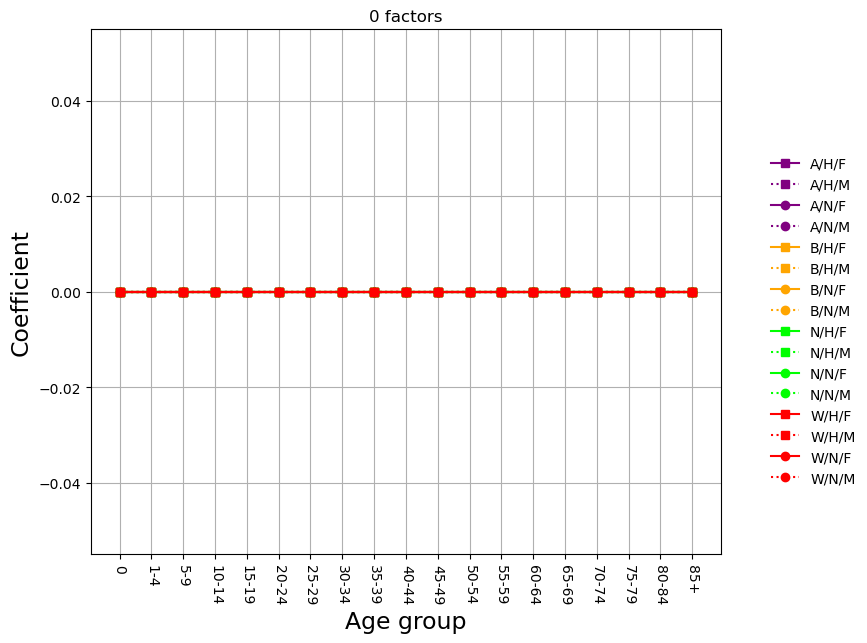

<Figure size 640x480 with 0 Axes>

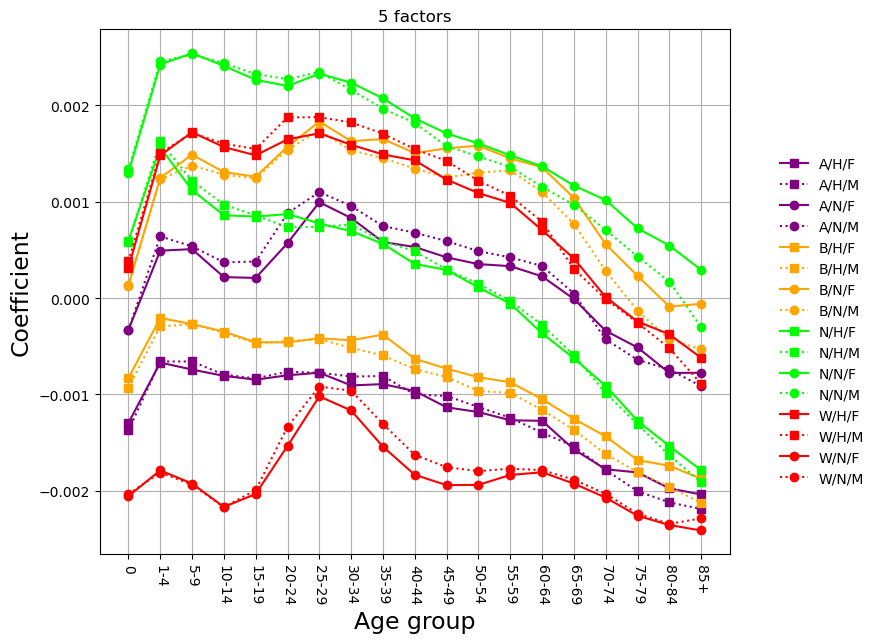

<Figure size 640x480 with 0 Axes>

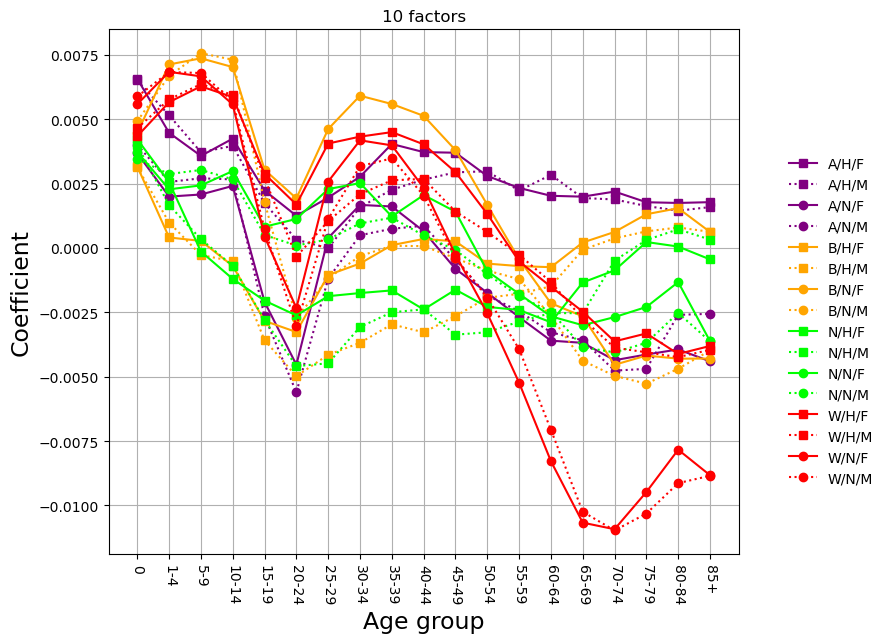

<Figure size 640x480 with 0 Axes>

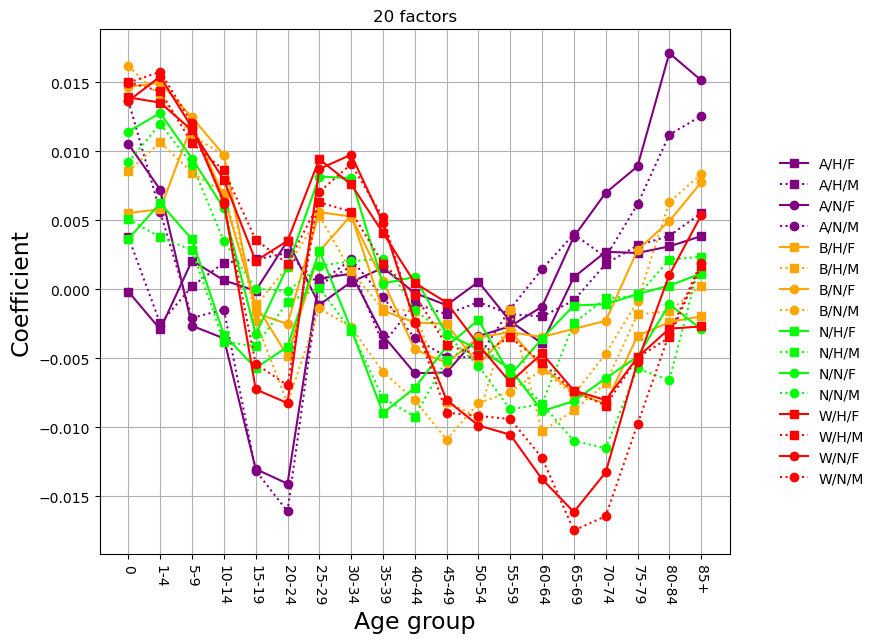

<Figure size 640x480 with 0 Axes>

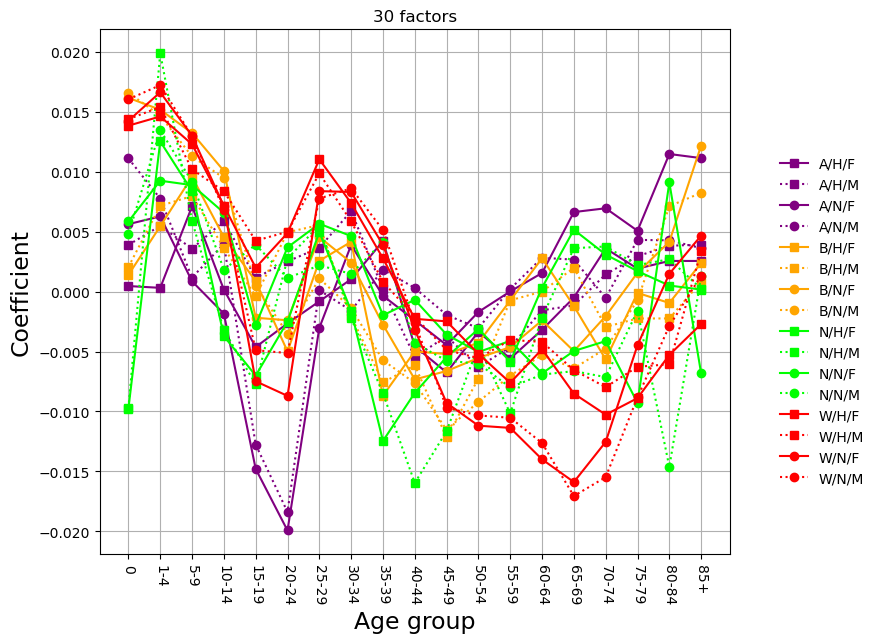

<Figure size 640x480 with 0 Axes>

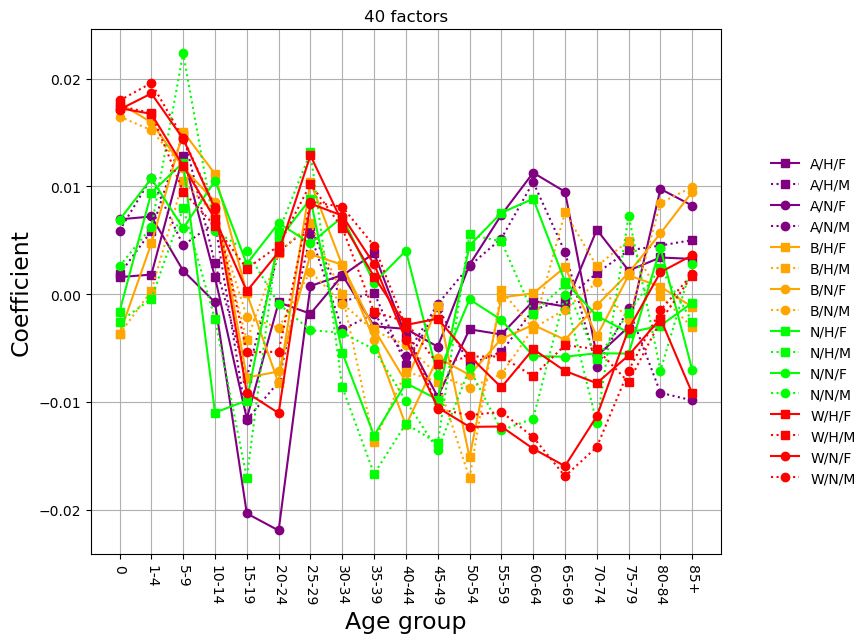

<Figure size 640x480 with 0 Axes>

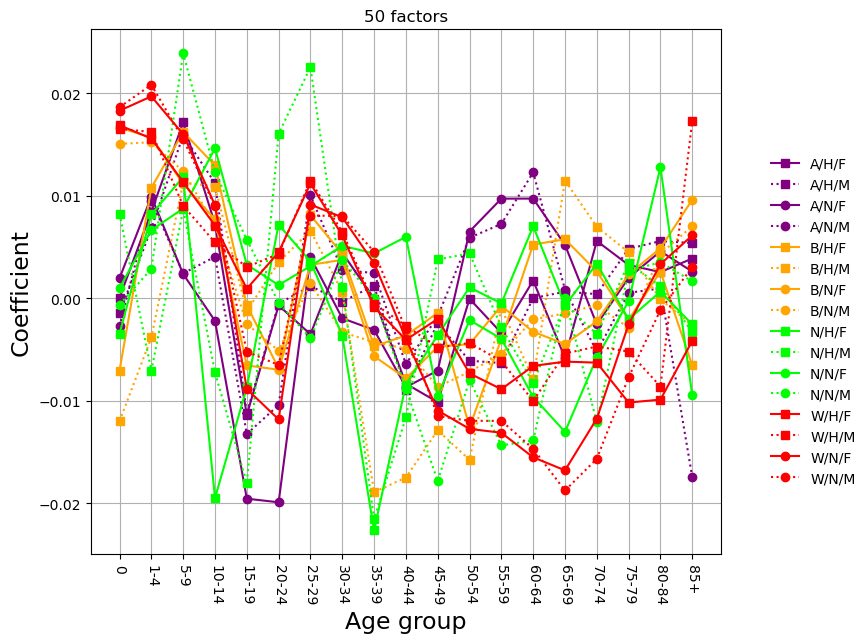

<Figure size 640x480 with 0 Axes>

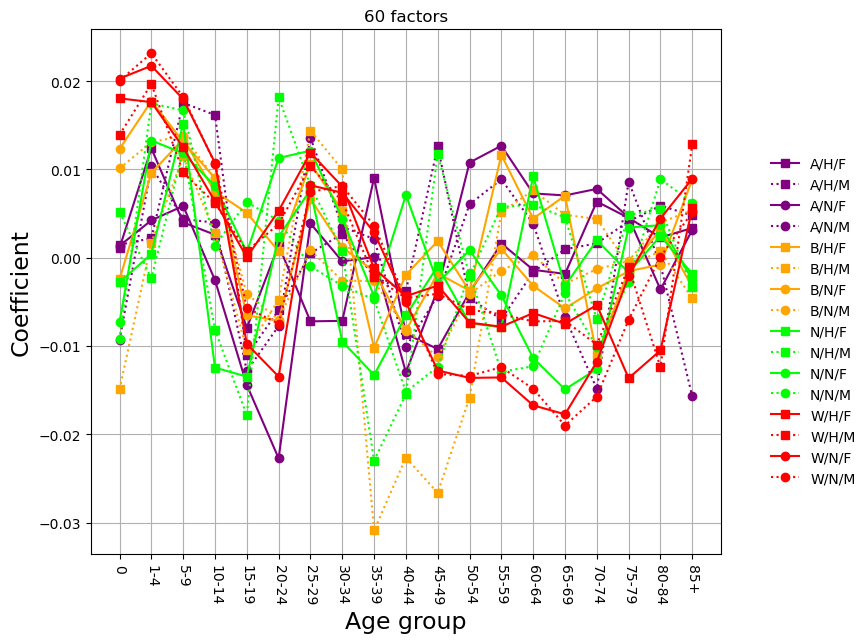

<Figure size 640x480 with 0 Axes>

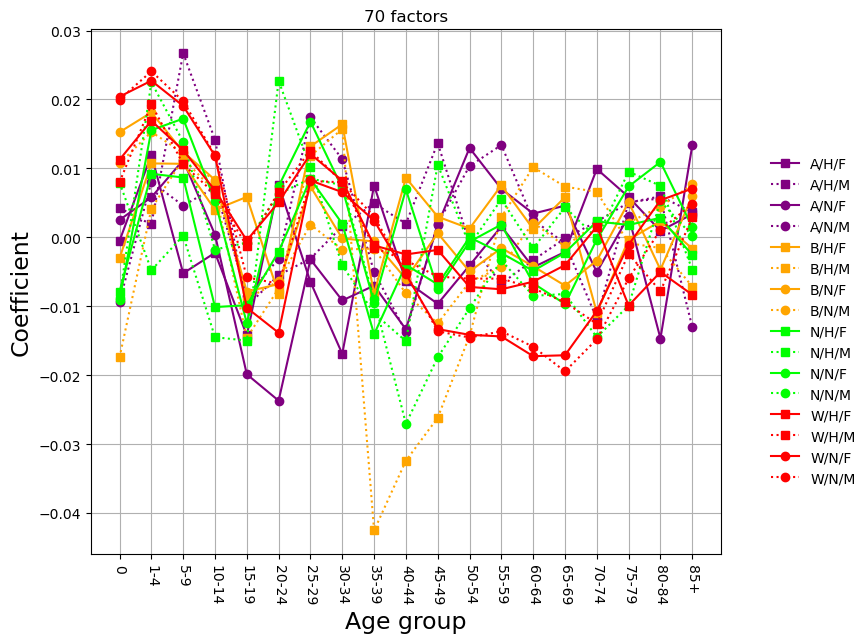

<Figure size 640x480 with 0 Axes>

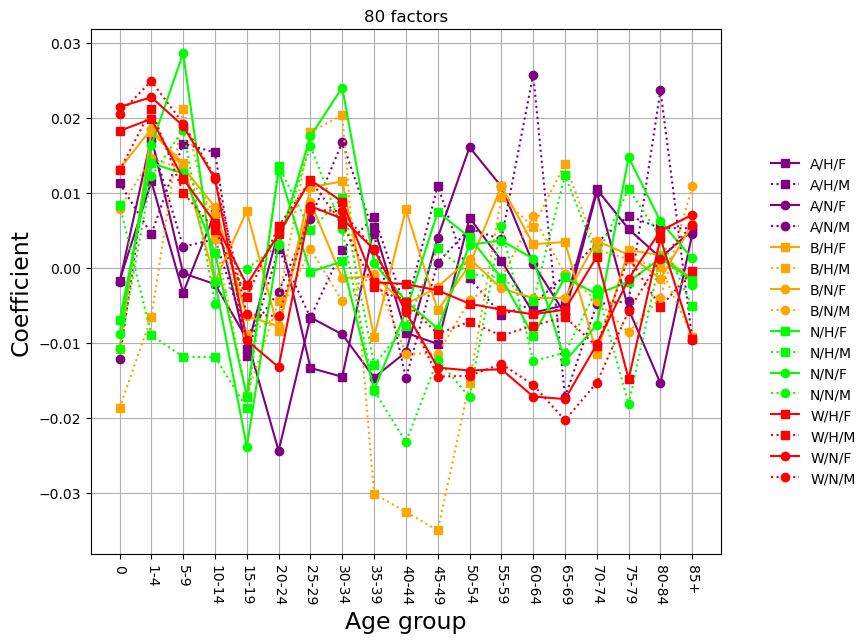

<Figure size 640x480 with 0 Axes>

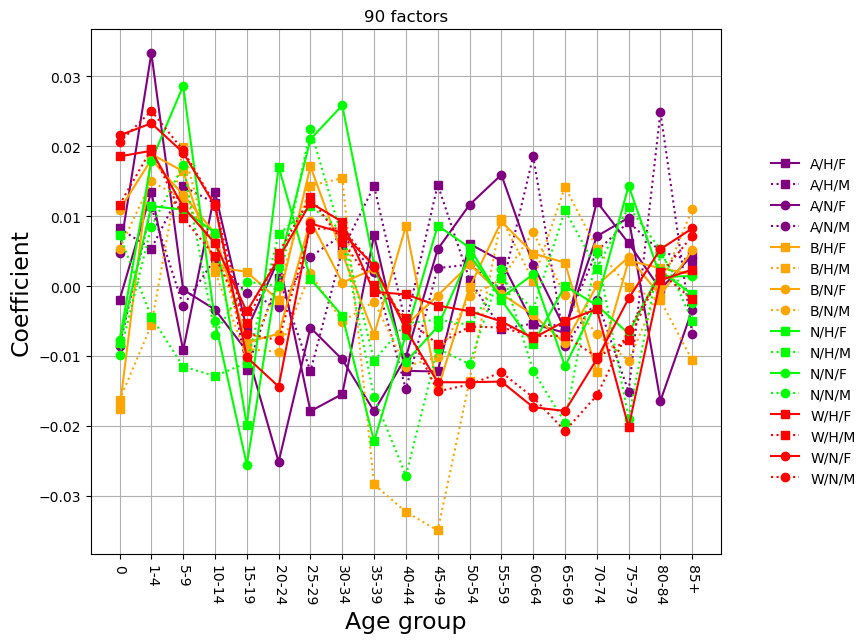

<Figure size 640x480 with 0 Axes>

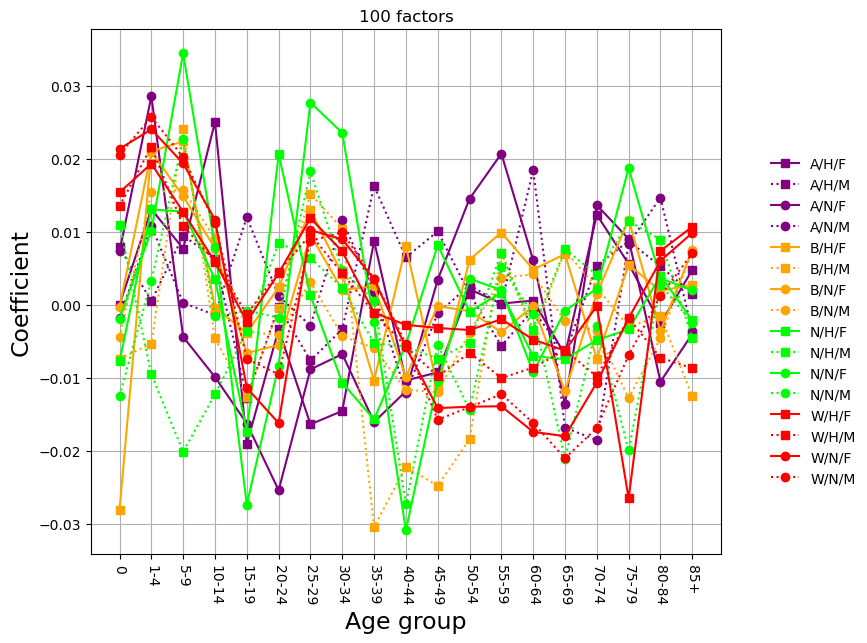

In [34]:
models = []
for npc in pcs:

    c, m, r = fitmodel(npc)
    models.append((m, r))

    plt.clf()
    plt.figure(figsize=(9, 7))
    ax = plt.axes([0.14, 0.18, 0.7, 0.75])
    ax.grid(True)
    for i in range(c.shape[0]):
        a = c.index[i]
        la = "/".join(a)
        ax.plot(ages, c.iloc[i, :], lt[a[2]] + sym[a[1]], color=colors[a[0]],
                label=la)

    # Setup the horizontal axis labels
    ax.set_xticks(ages)
    ax.set_xticklabels(age_groups)
    for x in plt.gca().get_xticklabels():
        x.set_rotation(-90)

    ha, lb = plt.gca().get_legend_handles_labels()
    leg = plt.figlegend(ha, lb, loc="center right")
    leg.draw_frame(False)

    plt.xlabel("Age group", size=17)
    plt.ylabel("Coefficient", size=17)
    plt.title("%d factors" % npc)
    plt.show()

Use score tests to get a sense of the number of PC factors to include; also consider the PVEs calculated above.

In [35]:
for k in range(10):
    st = models[k+1][0].compare_score_test(models[k][1])
    print("%d versus %d: p=%f" % (pcs[k+1], pcs[k], st["p-value"]))

5 versus 0: p=0.000000
10 versus 5: p=0.000000
20 versus 10: p=0.000000
30 versus 20: p=0.000117
40 versus 30: p=0.000003
50 versus 40: p=0.009136
60 versus 50: p=0.000959
70 versus 60: p=0.001466
80 versus 70: p=0.012965
90 versus 80: p=0.382202
